# FWI Example
We will peform FWI using the following steps:
1. [Prepare models](#models)
2. [Setup Constraints](#constraints) with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)
3. [Build a small local compute cluster (2 workers)](#cluster)
    * Take care of some HPC details related to thread affinity
4. [Create source and receivers geometries](#pos)
5. [Build `F`, the JUDI modeling operator](#buildF)
6. [Use `F` to create data for both models](#data)
7. [Visualize data](#vizD)
8. [Assess if data is cycle skipped at the farthest offsets](#cskiped)
9. [Build the `objective` function](#objective)
10. [Perform the FWI using `minConf_PQN`](#inversion) from [JUDI](https://github.com/slimgroup/JUDI.jl)
11. [Visualize velocity models and objective function](#plotres)
12. [Visualize data match](#matchD)
14. [Remove workers](#del)

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 16 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

In [1]:
# using Pkg
# pkg"add Distributed, DistributedArrays, DistributedJets, FFTW, JetPack, JetPackDSP, JetPackTransforms, JetPackWaveFD, Jets, LinearAlgebra, Optim, Printf, PyPlot, Random, WaveFD"
# Pkg.Registry.add(RegistrySpec(url="https://github.com/slimgroup/SLIMregistryJL.git"))
# pkg"add JOLI, SlimOptim, SetIntersectionProjection"

In [2]:
using Distributed, LinearAlgebra, Printf, Random
using JOLI, SlimOptim, SetIntersectionProjection
using PyPlot

## 1. Prepare models <a id='models'></a>

In [3]:
nz,nx = 251, 251;
dz,dx = 15.0, 15.0;
oz,ox = 0.0, 0.0;

vmin,vmax = 1500f0,1700f0
dmin,dmax = -0.25,+0.25

(-0.25, 0.25)

In [4]:
m0 = vmin * ones(Float32, nz, nx, 1);
m  = vmin * ones(Float32, nz, nx, 1);
m[101:150, 101:150, 1] .= vmax;

## Visualize

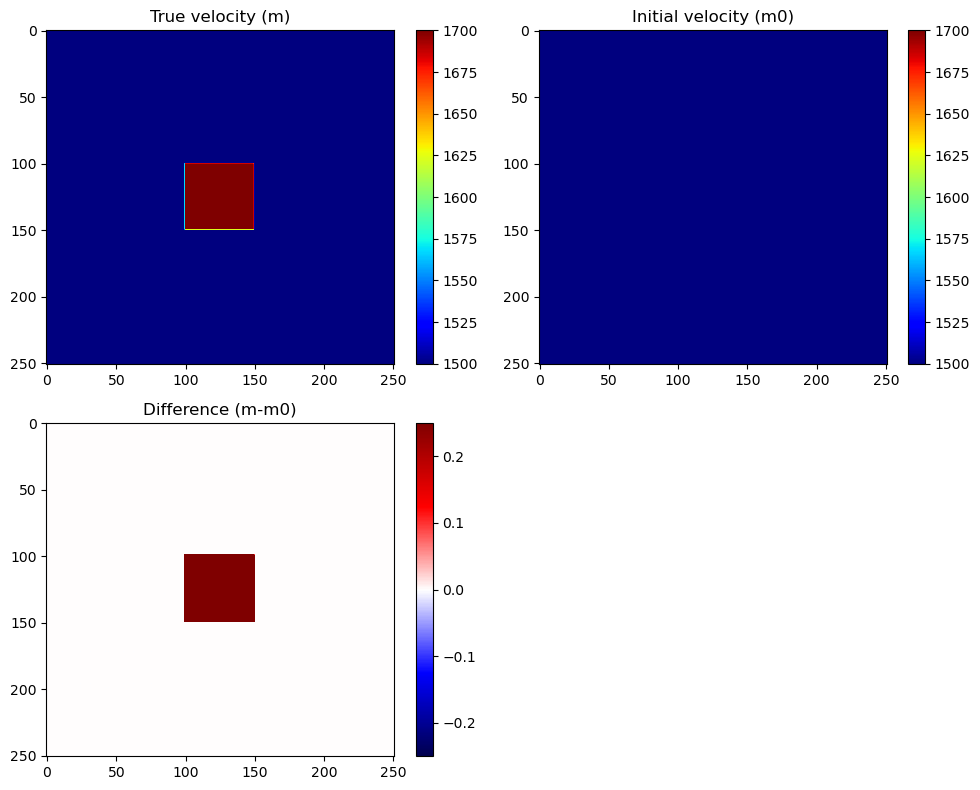

In [5]:
figure(figsize=(10,8))

subplot(2,2,1); imshow(m,aspect="auto",cmap="jet"); colorbar(); clim(vmin,vmax); title("True velocity (m)")
subplot(2,2,2); imshow(m0,aspect="auto",cmap="jet"); colorbar(); clim(vmin,vmax); title("Initial velocity (m0)");
subplot(2,2,3); imshow(m.-m0,aspect="auto",cmap="seismic"); colorbar(); clim(dmin,dmax); title("Difference (m-m0)");

tight_layout()

## 2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl) <a id='constraints'></a>

We setup two constaints:
- Bounds that limit minimum/maximum velocity
- TV, that limits variation and force a piece-wise constant structure

In [6]:
options1    = PARSDMM_options();
options1.FL = Float32;
options1    = default_PARSDMM_options(options1,options1.FL);
constraint1 = Vector{SetIntersectionProjection.set_definitions}(); # bounds only

options2    = PARSDMM_options();
options2.FL = Float32;
options2    = default_PARSDMM_options(options2,options2.FL);
constraint2 = Vector{SetIntersectionProjection.set_definitions}(); # bounds + TV

In [7]:
# model definition
struct grid
    n
    d
    o
end
model0 = grid((nz, nx), (dz, dx), (0., 0.))

grid((251, 251), (15.0, 15.0), (0.0, 0.0))

In [8]:
# bounds
m_min = vmin .* ones(Float32, nz, nx, 1)
m_max = vmax .* ones(Float32, nz, nx, 1)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint1, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));
push!(constraint2, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));

In [9]:
# TV
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options2.FL)
m_min = 0.0
m_max = norm(TV*reshape(m,:),1) * 0.5
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

In [10]:
# set up constraints and projection with bounds only
(P_sub1,TD_OP1,set_Prop1) = setup_constraints(constraint1,model0,options1.FL)
(TD_OP1,AtA1,l1,y1) = PARSDMM_precompute_distribute(TD_OP1,set_Prop1,model0,options1)
options1.rho_ini = ones(length(TD_OP1))*10.0
proj_intersection1 = x-> PARSDMM(x, AtA1, TD_OP1, set_Prop1, P_sub1, model0, options1)  

# Projection function
function prj1(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection1(reshape(input,:))
    @show "prj1; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

nothing

In [11]:
# set up constraints and projection with bounds + TV
(P_sub2,TD_OP2,set_Prop2) = setup_constraints(constraint2,model0,options2.FL)
(TD_OP2,AtA2,l2,y2) = PARSDMM_precompute_distribute(TD_OP2,set_Prop2,model0,options2)
options2.rho_ini = ones(length(TD_OP2))*10.0
proj_intersection2 = x-> PARSDMM(x, AtA2, TD_OP2, set_Prop2, P_sub2, model0, options2)

# Projection function
function prj2(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection2(reshape(input,:))
    @show "prj2; \n", extrema(input), extrema(x)
    return reshape(x,:)
end

nothing

#### test bounds constraints
Output should have `min 1500` and `max 1700`

In [12]:
v1 = vmin - (vmin + vmax) / 2;
v2 = vmax + (vmin + vmax) / 2;
m1 = v1 .+ (v2 - v1) .* rand(Float32,nz,nx,1);
m2 = prj1(m1);
@show extrema(m1);
@show extrema(m2);

stationary objective and reached feasibility, exiting PARSDMM (iteration 16)
("prj1; \n", extrema(input), extrema(x)) = ("prj1; \n", (-99.97568f0, 3299.9805f0), (1499.9954f0, 1700.0004f0))
extrema(m1) = (-99.97568f0, 3299.9805f0)
extrema(m2) = (1499.9954f0, 1700.0004f0)


## 3. Build a small local compute cluster (2 workers)  <a id='cluster'></a>

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [13]:
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))" 
addprocs(nw)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 21, 22)
(place1, place2, div(nthread, nw)) = (22, 43, 22)


In [14]:
@everywhere using Distributed, DistributedArrays, DistributedJets, FFTW, Jets, JetPack, JetPackDSP, JetPackTransforms
@everywhere using LinearAlgebra, Optim, Printf, Random, WaveFD, JetPackWaveFD
@everywhere using JOLI, SlimOptim, SetIntersectionProjection

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 4. Create source and receivers geometries <a id='pos'></a>
- We use 8 shot locations evenly distributed across the left of the model
- We use 251 receiver locations evenly distributed across the right of the model

In [15]:
@everywhere begin
    ntrec = 1501
    dtrec = 0.004
    dtmod = 0.002
    fpeak = 5.0 
end

In [16]:
nsrc = 8
zsrc = collect(Float32, range(oz, dz * (nz -1), length=nsrc));
xsrc = Float32(dz) .* ones(Float32, nsrc);
print("zsrc; ", zsrc, "\n")
print("xsrc; ", xsrc, "\n")

zsrc; Float32[0.0, 535.7143, 1071.4286, 1607.1428, 2142.8572, 2678.5715, 3214.2856, 3750.0]
xsrc; Float32[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]


In [17]:
nrec = 251
zrec = collect(Float32, range(oz, dz * (nz -1), length=nrec));
xrec = Float32(dz) * (nz - 2) .* ones(Float32, nrec);
print("zrec[1:10]; ", zrec[1:10], "\n")
print("xrec[1:10]; ", xrec[1:10], "\n")

zrec[1:10]; Float32[0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0]
xrec[1:10]; Float32[3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0]


#### Visualize geometry

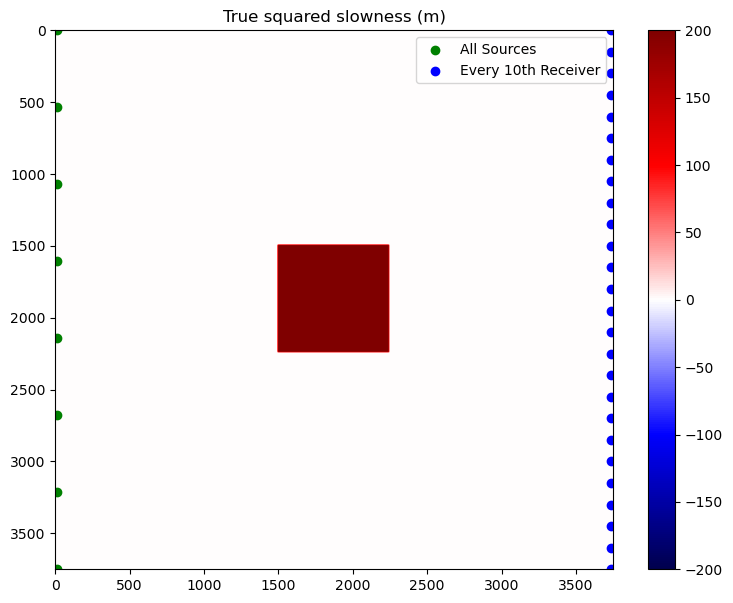

In [18]:
vmin,vmax = extrema(m)
dmin,dmax = -200,+200

figure(figsize=(9,7))
imshow(m .- m0,aspect="auto",cmap="seismic", extent=[0, 3750, 3750, 0]); 
colorbar(); clim(dmin,dmax); title("True squared slowness (m)")
PyPlot.scatter(xsrc, zsrc, c="g", label="All Sources")
PyPlot.scatter(xrec[1:10:end], zrec[1:10:end], c="b", label="Every 10th Receiver")
legend();

## 5. Build `F`, the modeling operator <a id='buildF'></a>

### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [19]:
@everywhere scratch = "/scratch"
@assert isdir(scratch)

@everywhere function makeF(i::Int,nz::Int,nx::Int,dz::Real,dx::Real,
        zsrc::Array{Float32},xsrc::Array{Float32},zrec::Array{Float32},xrec::Array{Float32})
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,nworkers()),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=fpeak),
        sx = xsrc[i],
        sz = zsrc[i],
        rx = xrec,
        rz = zrec,
        nbz_cache = nz,
        nbx_cache = 16,
        nsponge = 100,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval = 0)
end

In [20]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,zsrc,xsrc,zrec,xrec) for i in I[1], j in I[2]], (nsrc,1))

"Jet nonlinear operator, (251, 251, 1) → (3014008,)"

## 6. Use `F` to create the data in true and initial models <a id='data'></a>

In [21]:
t1 = @elapsed begin
    d = F * m;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

┌ Info: Time in true model; 27.46 seconds
└ @ Main In[21]:4


In [22]:
t2 = @elapsed begin
    d0 = F * m0;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in init model; 14.38 seconds
└ @ Main In[22]:4


#### Compute the residual data

In [23]:
r = d0 .- d;

## 7. Visualize data <a id='vizD'></a>

In [24]:
shots = [1,4,8];

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

scale = 31.15751259762597


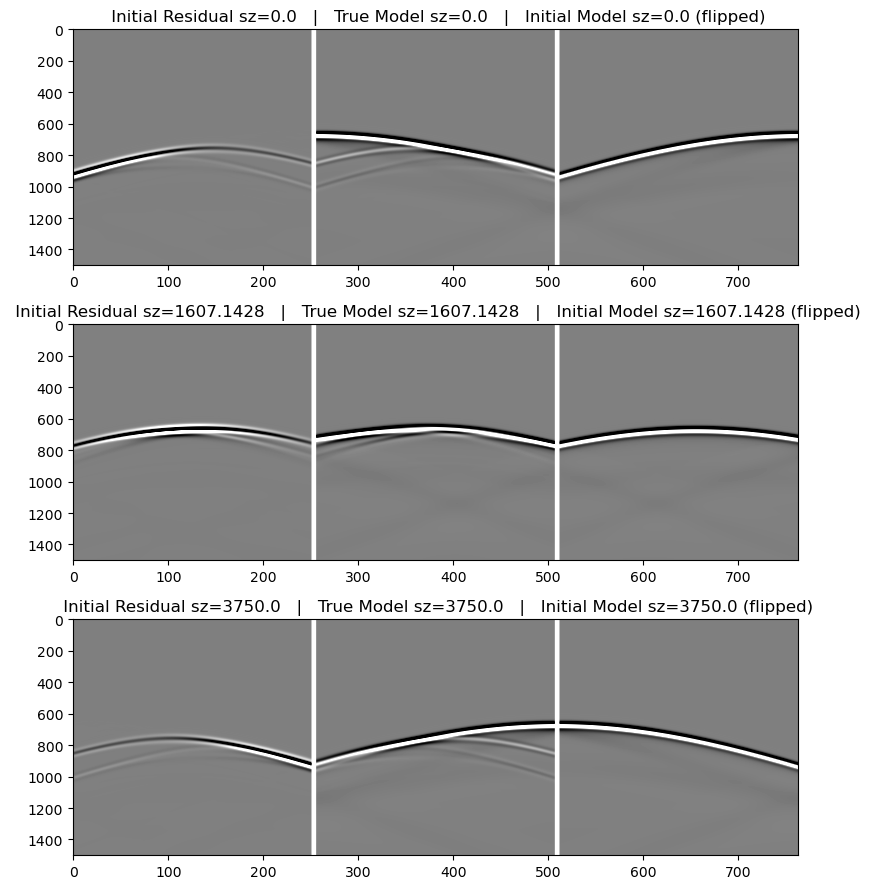

In [25]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    r_i  = getblock(r,ishot)
    cat2 = hcat(reverse(r_i,dims=2), pad, d_i, pad, reverse(d0_i,dims=2))
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[ishot])   |   True Model sz=$(zsrc[ishot])   |   Initial Model sz=$(zsrc[ishot]) (flipped)");
end
tight_layout()

## 8. Assess if data is cycle skipped at the farthest offsets <a id='cskiped'></a>
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

size(t) = (1501,)


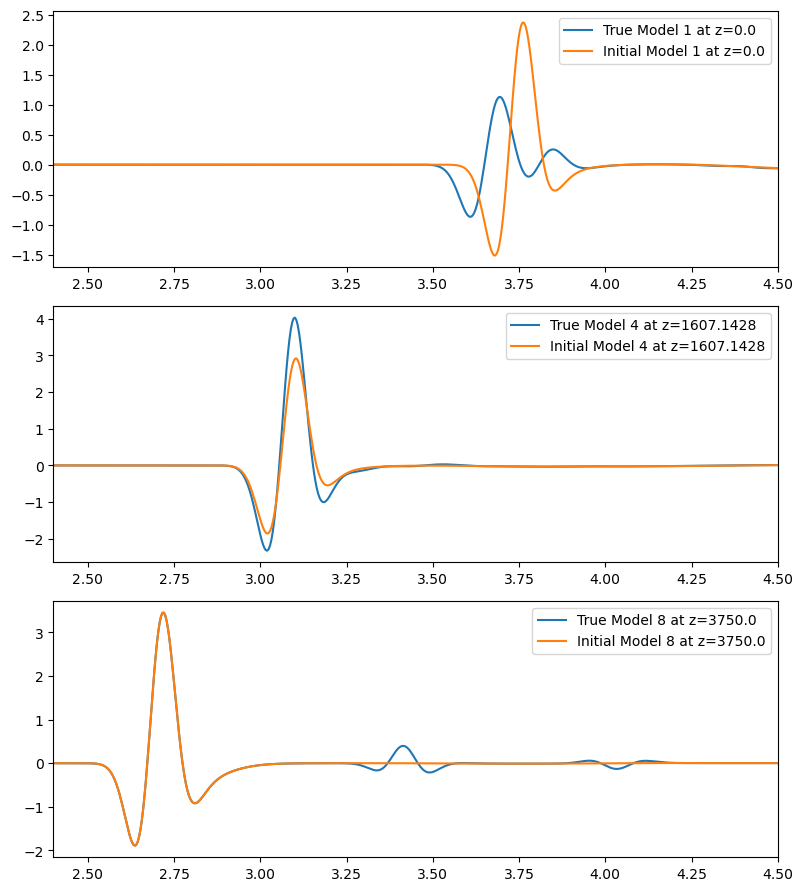

In [26]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
t = [0.0:dtrec:dtrec*(ntrec - 1);]
@show size(t)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    plot(t,d_i[:,end],label="True Model $(ishot) at z=$(zsrc[ishot])");
    plot(t,d0_i[:,end],label="Initial Model $(ishot) at z=$(zsrc[ishot])");
    xlim([2.4,4.5])
    legend()
end
tight_layout()

## 9. Build the `objective`  functions <a id='objective'></a>

#### Build src/rec positions mask
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever a source or receiver is close, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

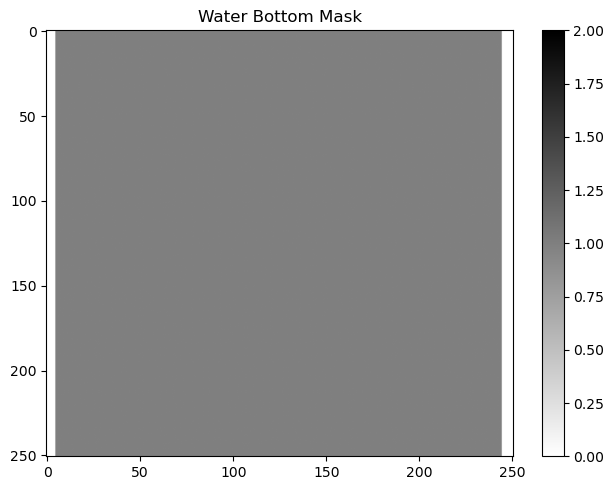

In [27]:
wb_mask = ones(Float32,size(m))
wb_mask[:, 1:5] .= 0;
wb_mask[:, end-5:end] .= 0;

figure(figsize=(6.5,5))
imshow(wb_mask[:,:,1], aspect="auto",cmap="gray_r",clim=[0,+2]);
colorbar();
title("Water Bottom Mask");
tight_layout()

#### Build the `objective` function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

In [28]:
@everywhere α = 0.5

global gscale = 0f0

function objective(F, _G, _m, d, wb_mask)
    m = reshape(_m, domain(F))
    J = jacobian(F,m)

    # illumination compensation
    s1 = srcillum(J)
    srms = sqrt(norm(s1)^2 / length(s1))
    s2 = s1 .+ eps(Float32) * srms
    s3 = s2.^(-α)
    s3 ./= maximum(s3)
    R  = JopDiagonal(reshape(s3, domain(F)))

    # modeling
    dm = zeros(range(F))
    t = @elapsed begin
        dm .= F * m
    end

    # gradient
    if _G != nothing
        G = reshape(_G, domain(F))
        G .= R ∘ J' * (dm .- d)
        G .*= wb_mask

        global gscale
        if gscale == 0.0
            # compute scalar from first gradient, apply to future gradients
            gscale = 25 ./ maximum(G) 
            @show gscale
        end
        G .*= gscale
        
        @show extrema(G)
    end

    ϕ = Float32(0.5 * norm(dm .- d)^2)
    @show ϕ
    
    return ϕ
end

# struct to save the first gradient scalar
global gscale = 0f0
f(x) = objective(F, nothing, x, d, wb_mask);
g!(G, x) = objective(F, G, x, d, wb_mask);
fg!(G, x) = objective(F, G, x, d, wb_mask);

#### Compute gradient

In [29]:
g1 = zeros(domain(F))
tg1 = @elapsed begin
    g!(g1, reshape(m0,:))
    gscale = 0
end
@show tg1;

gscale = 702.2101f0
extrema(G) = (-71.45005f0, 25.0f0)
ϕ = 102054.41f0
tg1 = 19.43694113


#### Visualize gradient

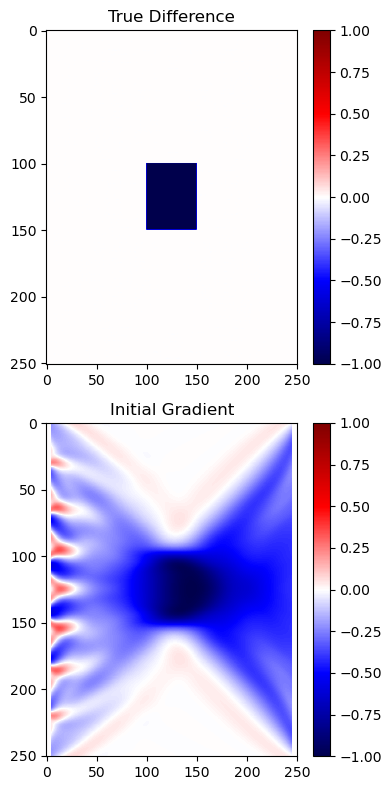

extrema(g1) = (-71.45005f0, 25.0f0)


In [30]:
dm = reshape(m0 .- m,nz,nx)
g1 = reshape(g1,nz,nx)

@show extrema(g1)

figure(figsize=(4,8))

subplot(2,1,1)
imshow(reshape(dm,nz,nx) ./ maximum(abs,dm),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("True Difference");

subplot(2,1,2)
imshow(reshape(g1,nz,nx) ./ maximum(abs,g1),aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient");

tight_layout()

## 10. Perform the FWI using `minConf_PQN` <a id='inversion'></a>
We will do 10 functions evaluation cost of projected quasi-Newton with two setup:
- Bounds constraints only
- Bounds + TV constrains

In [31]:
# FWI with PQN
niter = 10
options_pqn = pqn_options(progTol=0, store_trace=true, verbose=3, maxIter=niter)

SlimOptim.PQN_params(3, 1.0f-5, 0, 10, 0.0001f0, 10, false, true, true, 1.0f-6, 1.0f-7, 100, false, 20, 1, 1)

In [32]:
gscale = 0f0
mf1  = deepcopy(m0)
sol1 = pqn(f, g!, fg!, mf1, prj1, options_pqn);
mf1  = reshape(prj1(sol1.x),nz,nx)   # optimal solution
ϕ1   = sol1.ϕ_trace                  # cost vs iteration
m1   = sol1.x_trace                  # model vs iteration
collect(m1[i] = reshape(m1[i],nz,nx) for i=1:length(ϕ1));

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 10
Line search: BackTracking{Float32, Int64}
stationary objective and reached feasibility, exiting PARSDMM (iteration 15)
relative evolution to small, exiting PARSDMM (iteration 15)
("prj1; \n", extrema(input), extrema(x)) = ("prj1; \n", (0.0f0, 0.0f0), (1499.9989f0, 1499.9989f0))
gscale = 702.2273f0
extrema(G) = (-71.44802f0, 25.0f0)
ϕ = 102059.56f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
input to PARSDMM is feasible, returning
("prj1; \n", extrema(input), extrema(x)) = ("prj1; \n", (1474.9989f0, 1571.4469f0), (1474.9989f0, 1571.4469f0))
         0          0          0          0     0.00000e+00     

In [ ]:
gscale = 0f0
mf2  = deepcopy(m0)
sol2 = pqn(f, g!, fg!, mf2, prj2, options_pqn);
mf2  = reshape(prj2(sol2.x),nz,nx)  # optimal solution
ϕ2   = sol2.ϕ_trace                 # cost vs iteration
m2   = sol2.x_trace                 # model vs iteration
collect(m2[i] = reshape(m2[i],nz,nx) for i=1:length(ϕ2));

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 10
Line search: BackTracking{Float32, Int64}
stationary objective and reached feasibility, exiting PARSDMM (iteration 15)
relative evolution to small, exiting PARSDMM (iteration 15)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (0.0f0, 0.0f0), (1499.9982f0, 1499.9987f0))
gscale = 702.22906f0
extrema(G) = (-71.44624f0, 25.0f0)
ϕ = 102060.51f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1474.9987f0, 1571.445f0), (1499.9979f0, 1571.4073f0))
         0          0          0          0 

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1499.9983f0, 1562.6367f0), (1499.9999f0, 1562.6306f0))
ϕ = 23245.254f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1499.9999f0, 1562.6306f0), (1500.0001f0, 1562.6268f0))
extrema(G) = (-43.64636f0, 33.24339f0)
ϕ = 23250.592f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1466.759f0, 1605.5797f0), (1499.9987f0, 1605.4945f0))
         2          3          3         28     1.00000e+00     2.32453e+04     4.35636e+01
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1485.4291f0, 1581.3401f0), (1499.999f0, 1581.296f0))
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1460.3384f0, 1585.8239f0), (1499.99

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 15)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1500.0012f0, 1584.2815f0), (1500.0012f0, 1584.2655f0))
ϕ = 13542.532f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1500.0012f0, 1584.2655f0), (1500.0021f0, 1584.2528f0))
extrema(G) = (-27.200686f0, 28.051336f0)
ϕ = 13549.831f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1471.951f0, 1609.4613f0), (1499.9984f0, 1609.3938f0))
         3          4          4         42     1.00000e+00     1.35425e+04     2.70745e+01
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1454.2678f0, 1625.4395f0), (1499.9985f0, 1625.3711f0))
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1465.2362f0, 1617.7719f0), (149

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 15)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1500.0001f0, 1619.788f0), (1500.0106f0, 1611.5061f0))
ϕ = 6804.7695f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1500.0106f0, 1611.5061f0), (1500.007f0, 1611.4996f0))
extrema(G) = (-15.671746f0, 23.261784f0)
ϕ = 6801.233f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1478.3102f0, 1622.4845f0), (1499.9995f0, 1622.2538f0))
         4          5          5         58     1.00000e+00     6.80477e+03     1.56249e+01
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1414.7102f0, 1664.7854f0), (1499.9998f0, 1664.3641f0))
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1472.8002f0, 1639.9886f0), (1500.

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 15)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1500.0004f0, 1636.8529f0), (1499.9998f0, 1636.7465f0))
ϕ = 2856.553f0
relative evolution to small, exiting PARSDMM (iteration 15)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1499.9998f0, 1636.7465f0), (1500.0015f0, 1636.6501f0))
extrema(G) = (-11.285359f0, 13.557073f0)
ϕ = 2858.2388f0
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1486.4443f0, 1646.4846f0), (1499.9996f0, 1646.0554f0))
         5          6          6         88     1.00000e+00     2.85655e+03     1.12581e+01
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1456.054f0, 1669.8517f0), (1499.9988f0, 1667.831f0))
relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1471.8334f0, 1652.509f0), (1499.9

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 17)
("prj2; \n", extrema(input), extrema(x)) = ("prj2; \n", (1499.9999f0, 1635.2646f0), (1500.0029f0, 1635.2645f0))
ϕ = 3135.4014f0
ϕ = 2944.1853f0
ϕ = 2887.7048f0
ϕ = 2869.719f0
ϕ = 2863.017f0
ϕ = 2860.452f0
ϕ = 2859.2893f0
ϕ = 2858.784f0
ϕ = 2858.5867f0
ϕ = 2858.315f0
ϕ = 2858.218f0
ϕ = 2858.214f0


## 11. Visualize velocity models and objective function  <a id='plotres'></a>

In [ ]:
figure(figsize=(10,8)); clf()

m   = reshape(m,nz,nx)
m0  = reshape(m0,nz,nx)

subplot(2,2,1);imshow(m0,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(2,2,2);imshow(m,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

subplot(2,2,3);imshow(mf2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity with bounds");

subplot(2,2,4);imshow(mf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity with bounds + TV");

tight_layout()

#### Display the velocity difference models 

In [ ]:
rms_v0 = @sprintf("%.1f m/s", sqrt(norm(m .- m0)^2 / length(m)))
rms_v1 = @sprintf("%.1f m/s", sqrt(norm(m .- mf1)^2 / length(m)))
rms_v2 = @sprintf("%.1f m/s", sqrt(norm(m .- mf2)^2 / length(m)))

figure(figsize=(10,8)); clf()

subplot(2,2,1);imshow(m .- m0,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vinit difference, rms=$(rms_v0)");

subplot(2,2,2);imshow(m .- mf1,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference (bounds), rms=$(rms_v1)");

subplot(2,2,3);imshow(m .- mf2,aspect="auto",cmap="seismic");
colorbar(orientation="vertical");clim(dmin,dmax);
title("Vtrue - Vfwi difference (bounds + TV), rms=$(rms_v2)");

tight_layout()

#### Display the cost function 

In [ ]:
figure(figsize=(8,5)); clf()
iters = [0:1:niter;]
plot(ϕ1[2:end] ./ ϕ1[2], marker="o", label="FWI + bounds")
plot(ϕ2[2:end] ./ ϕ2[2], marker="+", label="FWI + bounds + TV")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title(@sprintf("FWI Objective Function reduced %.1f%% (bounds) and %.1f%% (bounds + TV)",
        100 * (ϕ1[2] - ϕ1[end]) / ϕ1[2], 100 * (ϕ2[2] - ϕ2[end]) / ϕ2[2]));
tight_layout()

#### Display data misfit vs model misfit

In [ ]:
figure(figsize=(8,4)); clf()

c1 = [norm(m1[i] .- m, 2) for i in 1:length(m1)]
c2 = [norm(m2[i] .- m, 2) for i in 1:length(m2)]
loglog(c1[2:end], ϕ1[2:end], label="FWI + bounds", marker="o", linewidth=1)
loglog(c2[2:end], ϕ2[2:end], label="FWI + bounds + TV", marker="+", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory");
tight_layout()

## 12. Visualize data match <a id='matchD'></a>
#### Generate data in the FWI velocity model

In [ ]:
tf = @elapsed begin
    d1 = F * reshape(mf1, domain(F));
end
@show tf;

tf2 = @elapsed begin
    d2 = F * reshape(mf2, domain(F));
end
@show tf2;

#### Compute residuals

In [ ]:
r1 = d1 .- d;
r2 = d2 .- d;

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data<br>(flipped)</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Residual Data<br>(flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Data<br>(flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [ ]:
zsrc = trunc.(zsrc; digits=6)

function make_plot(index)
    figure(figsize=(8,6)); clf()
    
    d_i  = getblock(d,index)

    d0_i = getblock(d0,index)
    d1_i = getblock(d1,index)
    d2_i = getblock(d2,index)

    r0_i = getblock(r0,index)
    r1_i = getblock(r1,index)
    r2_i = getblock(r2,index)
    
    cat0 = hcat(reverse(r0,dims=2), pad, d, pad, reverse(d0,dims=2))
    cat1 = hcat(reverse(r1,dims=2), pad, d, pad, reverse(d1,dims=2))
    cat2 = hcat(reverse(r2,dims=2), pad, d, pad, reverse(d2,dims=2))

    subplot(3,1,1);
    imshow(cat0,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   Initial sz=$(zsrc[index]) (flipped)");
    
    subplot(3,1,2);
    imshow(cat1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" FWI (+bounds) Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   FWI (+bounds) sz=$(zsrc[index]) (flipped)");
    
    subplot(3,1,3);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("FWI (+bounds +TV) Residual sz=$(zsrc[index])   ||   True sz=$(zsrc[index])   ||   FWI (+bounds +TV) sz=$(zsrc[index]) (flipped)");

    tight_layout()
end

#### Data for the 1st shot, generated in the initial and FWI models

In [ ]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

In [ ]:
make_plot(4)

#### Data for the 8th shot, generated in the initial and FWI models

In [ ]:
make_plot(8)

## 14. Remove workers <a id='del'></a>

In [ ]:
rmprocs(workers());